_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 6)                 240       
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 14        
Total params: 254
Trainable params: 254
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
994/994 [==============================] - 2s 2ms/step - loss: 12.8537
Epoch 2/25
994/994 [==============================] - 0s 392us/step - loss: 10.4765
Epoch 3/25
994/994 [==============================] - 0s 401us/step - loss: 8.2814
Epoch 4/25
994/994 [==============================] - 0s 395us/step - loss: 6.1384
Epoch 5/25
994/994 [==============================] - 0s 395us/step - loss: 4.7639
Epoch 6/25
994/994 [==============================] - 0s 398us/step - loss: 3.9456
Epoch 7/25
994/994 [======================

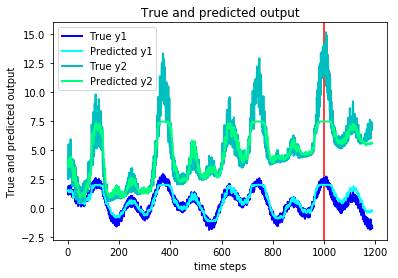

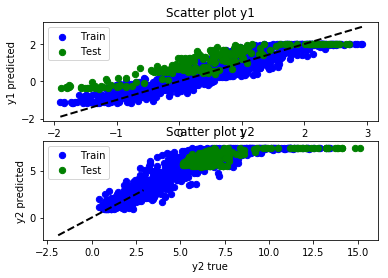

Train time series 
             y1       y2 
MSE         0.13     1.49
RMSE        0.36     1.22
Corr coef   0.94     0.90
Corr coef p 0.00     0.00

Test time series 
             y1       y2 
MSE         0.61     4.30
RMSE        0.78     2.07
Corr coef   0.92     0.73
Corr coef p 0.00     0.00


In [4]:
#LSTM for multidimensional time series analysis X and Y
#https://keras.io/layers/recurrent/#lstm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM
from sklearn.metrics import mean_squared_error
import math
from scipy.stats import pearsonr 
%matplotlib inline

# convert into dataset matrix
def convertToMatrix(data, step):
 X, Y =[], []
 for i in range(len(data)-step):
  d=i+step  
  X.append(data[i:d,])
  Y.append(data[d,])
 return np.array(X), np.array(Y)


#------------------------------------------------------------------------------
#parameters
#------------------------------------------------------------------------------
N=1200    #number of time steps
n=1000     #number of time steps for training  
step = 6  #number of time steps as inputs for each feature

lw=2 # line width 

#------------------------------------------------------------------------------
#Data generation
#------------------------------------------------------------------------------

#time step vector 0-N
t=np.arange(0,N) 
#features x1-x3
x1=np.sin(0.02*t)+np.cos(0.05*t)+1*np.random.rand(N) #sin + cos + noise
x2=np.square(x1)
x3=(0.005*t)
#time series y1-y2
y1=x1
y2=x1+x2+x3


#Features X, output to be predicted Y
X=np.column_stack((x1, x2, x3))
Y=np.column_stack((y1, y2))

#Training and test data
xtrain0, xtest0 = X[0:n,:], X[n:N,:]
ytrain0, ytest0 = Y[0:n,:], Y[n:N,:]

#function to form data for RNN
#creates x and y data for a given step window
def convertData(datax,datay,step):
 X, Y = [], []
 for i in range(len(datax)-step):
  d = i+step  
  X.append(datax[i:d,])
  Y.append(datay[d])
 return np.array(X), np.array(Y)

#call function to form data sets for training
testx,testy = convertData(xtest0,ytest0, step)
trainx,trainy = convertData(xtrain0,ytrain0, step)

#e.g. xtest0 consists of two features x1 and x2
#array([[ 1, 10],
#       [ 2, 20],
#       [ 3, 30],
#       [ 4, 40],
#       [ 5, 50]])
#ytest0 is two-dimensional output
#array([[100, 110],
#       [200, 220],
#       [300, 330],
#       [400, 440],
#       [500, 550]])
#then convertData(xtest0,ytest0, step) with step=2 creates arrays:
#inputs testx:
#array([[[ 1, 10],
#        [ 2, 20]],
#       [[ 2, 20],
#        [ 3, 30]],
#       [[ 3, 30],
#        [ 4, 40]]])
#outputs to predict testy:
#array([[300, 330],
#       [400, 440],
#       [500, 550]])



#------------------------------------------------------------------------------
#LSTM neural network 
#------------------------------------------------------------------------------

#parameters for RNN
#input dimensions 
in_dim = trainx.shape[1:3]
#output dimensions 
out_dim = trainy.shape[1]

#Recurrent neural network
#Sequential model
model = Sequential()

#single LSTM layer
units1=6  # Positive integer, dimensionality of the output space
model.add(LSTM(units1, input_shape=in_dim))

#2 LSTM layers
#units1=4
#units2=2
#model.add(LSTM(units1, input_shape=in_dim))
#model.add(LSTM(units2)) # returns a sequence of vectors of dimension units2

model.add(Dense(out_dim, activation='linear'))
#output layer, out_dim outputs
model.compile(loss='mse', optimizer='adam')
#Configures the model for training
#https://keras.io/optimizers/
#optimizer='adam'
model.summary()
#https://www.tensorflow.org/api_docs/python/tf/keras/layers/SimpleRNN

#training
model.fit(trainx,trainy, epochs=25, batch_size=16, verbose=1)
#prediction errors
trainScore = model.evaluate(trainx, trainy, verbose=0)
#print(trainScore)

#prediction
predtrain= model.predict(trainx)
predtest= model.predict(testx)


#------------------------------------------------------------------------------
#Plots
#------------------------------------------------------------------------------
#data y1 and y2 used for training and testing
data_y1=np.concatenate((trainy[:,0], testy[:,0]),axis=0)
data_y2=np.concatenate((trainy[:,1], testy[:,1]),axis=0)
#prediction y1 and y2
predicted_y1=np.concatenate((predtrain[:,0], predtest[:,0]),axis=0)
predicted_y2=np.concatenate((predtrain[:,1], predtest[:,1]),axis=0)
#join a sequence of arrays along an existing axis

#time step vector
n1=data_y1.shape[0]
#time step vector 0-N
t=np.arange(0,n1) 

#Plot outputs and predictions as a function of time
plt.figure(1) #create a new figure
plt.axvline(n, c="r") #vertical line to separate train and test data sequencies
plt.plot(t,data_y1, 'b', lw=lw, label="True y1") #y1 
plt.plot(t,predicted_y1, 'aqua', lw=lw, label="Predicted y1") #y1 predicted
plt.plot(t,data_y2, 'c', lw=lw, label="True y2") #y2 
plt.plot(t,predicted_y2, 'springgreen', lw=lw, label="Predicted y2") #y2 predicted
plt.legend(loc='upper left')
plt.xlabel('time steps')
plt.ylabel('True and predicted output')
plt.title('True and predicted output')
plt.savefig('Fig1_timeSeries.png')
plt.show()


#Plot outputs and predictions in a scatter plot
plt.figure(2) #create a new figure
#output y1
plt.subplot(2, 1, 1)
plt.scatter(trainy[:,0], predtrain[:,0], label='Train', color='b', s=40, marker="o" )
plt.scatter(testy[:,0], predtest[:,0], label='Test', color='g', s=40, marker="o" )
#min and max values
range_y1_max=max(np.concatenate((trainy[:,0], predtrain[:,0], testy[:,0], predtest[:,0]),axis=0))
range_y1_min=min(np.concatenate((trainy[:,0], predtrain[:,0], testy[:,0], predtest[:,0]),axis=0))
#diagonal line
plt.plot([range_y1_min, range_y1_max], [range_y1_min, range_y1_max], 'k--', lw=lw)
plt.legend(loc='upper left')
plt.xlabel('y1 true')
plt.ylabel('y1 predicted')
plt.title('Scatter plot y1')

#output y2
plt.subplot(2, 1, 2)
plt.scatter(trainy[:,1], predtrain[:,1], label='Train', color='b', s=40, marker="o" )
plt.scatter(testy[:,1], predtest[:,1], label='Test', color='g', s=40, marker="o" )
#min and max values
range_y2_max=max(np.concatenate((trainy[:,1], predtrain[:,1], testy[:,1], predtest[:,1]),axis=0))
range_y2_min=min(np.concatenate((trainy[:,1], predtrain[:,1], testy[:,1], predtest[:,1]),axis=0))
#diagonal line
plt.plot([range_y1_min, range_y1_max], [range_y1_min, range_y1_max], 'k--', lw=lw)
plt.legend(loc='upper left')
plt.xlabel('y2 true')
plt.ylabel('y2 predicted')
plt.title('Scatter plot y2')
plt.savefig('Fig2_scatterplot.png')
plt.show()

#------------------------------------------------------------------------------
#Estimation of the prediction accuracy
#------------------------------------------------------------------------------

#train sequence
predtrain= model.predict(trainx)
#Mean squared error
mse_train_y1=mean_squared_error(trainy[:,0], predtrain[:,0])
mse_train_y2=mean_squared_error(trainy[:,1], predtrain[:,1])

#Root mean squared error
rmse_train_y1 =  np.sqrt(mean_squared_error(trainy[:,0], predtrain[:,0]))
rmse_train_y2 = np.sqrt(mean_squared_error(trainy[:,1], predtrain[:,1]))

#Correlation coefficients between y and prediction
#p value <0.05 shows that correlation coefficient is statistically significant
correlation_train_y1 = pearsonr(trainy[:,0], predtrain[:,0])
correlation_train_y2 = pearsonr(trainy[:,1], predtrain[:,1])

#test sequence
predtest= model.predict(testx)
#Mean squared error
mse_test_y1=mean_squared_error(testy[:,0], predtest[:,0])
mse_test_y2=mean_squared_error(testy[:,1], predtest[:,1])

#Root mean squared error
rmse_test_y1 =  np.sqrt(mean_squared_error(testy[:,0], predtest[:,0]))
rmse_test_y2 = np.sqrt(mean_squared_error(testy[:,1], predtest[:,1]))

#Correlation coefficients between y and prediction
#p value <0.05 shows that correlation coefficient is statistically significant
correlation_test_y1 = pearsonr(testy[:,0], predtest[:,0])
correlation_test_y2 = pearsonr(testy[:,1], predtest[:,1])

print("Train time series "  )
print("             y1       y2 "  )
print("MSE         %.2f     %.2f" % (mse_train_y1, mse_train_y2))
print("RMSE        %.2f     %.2f" % (rmse_train_y1, rmse_train_y2))
print("Corr coef   %.2f     %.2f" % (correlation_train_y1[0], correlation_train_y2[0]))
print("Corr coef p %.2f     %.2f" % (correlation_train_y1[1], correlation_train_y2[1]))

print("\nTest time series "  )
print("             y1       y2 "  )
print("MSE         %.2f     %.2f" % (mse_test_y1, mse_test_y2))
print("RMSE        %.2f     %.2f" % (rmse_test_y1, rmse_test_y2))
print("Corr coef   %.2f     %.2f" % (correlation_test_y1[0], correlation_test_y2[0]))
print("Corr coef p %.2f     %.2f" % (correlation_test_y1[1], correlation_test_y2[1]))

#%reset -f

#https://www.tensorflow.org/guide/keras/rnn
#https://keras.io/layers/recurrent/
